#Import and install modules

In [1]:
!pip install hazm

In [2]:
!pip show hazm

Name: hazm
Version: 0.7.0
Summary: Python library for digesting Persian text.
Home-page: http://www.sobhe.ir/hazm/
Author: Alireza Nourian
Author-email: az.nourian@gmail.com
License: UNKNOWN
Location: /usr/local/lib/python3.6/dist-packages
Requires: nltk, libwapiti
Required-by: 


In [3]:
import re, hazm, os, json, nltk
import pickle
import numpy as np
import pandas as pd
from nltk import word_tokenize 
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
nltk.download('wordnet')
nltk.download("stopwords")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#Load data

In [5]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("drive/My Drive")
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 AI-4.gdoc
 alberta.gdoc
 apply.gsheet
 classifier
'Colab Notebooks'
 CV.pdf
'Email for Graduate Application.gdoc'
'My Prof.s.gsheet'
 nb_bilang.sav
 nb_en.sav
 nb_fa.sav
 nlp-project.ipynb
 Prof.s.gsheet
'project Bsc'
'Recommendation Letter_Rezvan Karaji_Nevada.rtf'
 rf_bilang.sav
 rf_en.sav
 rf_fa.sav
 SpamDetection.ipynb
 tfidf_bilang.sav
 tfidf_en.sav
 tfidf_fa.sav
 transcript-official.pdf
 tweet.csv


In [6]:
filename = 'tweet.csv'
data = pd.read_csv(filename, encoding='utf-8')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,5,6,11,12,13,43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#analyze data

In [7]:
data.head()

,Unnamed: 0,id,username,title,about,members,posts_count,language,avg_view,last_dump_date,last_cold_date,duration_update,following_count,verified,favourites_count,location,url,join_date,deleted,index_name,UTC_date,date,views,retweet_count,text,fwdfrom,media,hashtags,to,from,post_id,link,dump_type,meta,is_adv,bi-keywords,keywords,neg_adj,pos_adj,sentiment,mentions,locations,urls,cashtags
0,0,9.772081e+17,jasooyichii,milad mohammadi,Exhibitions reporter/\nmr event/\norganizer of...,856,470,NaN,0.0,2020-10-26,2020-10-09,24,774,0,1927.0,tehran - iran,https://t.co/uz1hdKY1V8,2018-03-23T15:38:55,0.0,tw-sourceinfo-2020-10,2020-10-25T20:40:58,2020-10-25 17:10:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.314951e+18,NaN,NaN,NaN,NaN,NaN,fa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tw-user-2020-10,2020-10-10T15:29:51,2020-10-10 15:29:51,7897.0,457.0,آن شب اسفندماه که برای نخستین بار خبر درگذشت #...,"{'username': 'febrahimzade', 'id': '198563041'...",{'caption': 'آن شب اسفندماه که برای نخستین بار...,"['محمدرضاشجریان', 'افسانه_شجریان']","{'participants_count': 181, 'username': 'lonel...","{'participants_count': 181, 'username': 'lonel...",1886.0,https://twitter.com/i/web/status/1314951285540...,scheduled,['اجتماعی'],1.0,"['اسفندماه خبر', 'خبر درگذشت', 'درگذشت محمدرضا...","['پدر', 'درگذشت', 'علاقه', 'بیمارستان', 'پاسخ'...","['بار', 'درگذشت']","['آرامش', 'باور', 'زنده']",positive,NaN,NaN,NaN,NaN
2,2,1.314951e+18,NaN,NaN,NaN,NaN,NaN,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tw-user-2020-10,2020-10-10T15:28:26,2020-10-10 15:28:26,1.0,0.0,@daydreaminblack Niiiice😂😂😂😂😂,NaN,NaN,NaN,"{'participants_count': 181, 'username': 'lonel...","{'participants_count': 181, 'username': 'lonel...",1885.0,https://twitter.com/i/web/status/1314950928517...,scheduled,['متفرقه'],0.0,[],"['daydreaminblack', 'Niiiice']",NaN,NaN,neutral,['daydreaminblack'],NaN,NaN,NaN
3,3,1.314951e+18,NaN,NaN,NaN,NaN,NaN,fa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tw-user-2020-10,2020-10-10T15:28:00,2020-10-10 15:28:00,33.0,1.0,جدا از رفتن شجریان، چهر‌ه‌های غمبار همایون و ع...,"{'username': 'helia_hh', 'id': '3025201221', '...",NaN,NaN,"{'participants_count': 181, 'username': 'lonel...","{'participants_count': 181, 'username': 'lonel...",1884.0,https://twitter.com/i/web/status/1314950817338...,scheduled,['هنری'],0.0,"['رفتن شجریان', 'شجریان چهر', 'چهر غمبار', 'غم...","['رفتن', 'شجریان', 'مچاله', 'علیزاده', 'چهر', ...","['جدا', 'مچاله']",NaN,negative,NaN,NaN,NaN,NaN
4,4,1.314895e+18,NaN,NaN,NaN,NaN,NaN,fa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tw-user-2020-10,2020-10-10T11:47:36,2020-10-10 11:47:36,3046.0,191.0,دیگه تویی که تا دیروز عکس سردار دلها رو استوری...,"{'username': 'Javadhastam2', 'id': '1111065915...",{'caption': 'دیگه تویی که تا دیروز عکس سردار د...,NaN,"{'participants_count': 181, 'username': 'lonel...","{'participants_count': 181, 'username': 'lonel...",1883.0,https://twitter.com/i/web/status/1314895352772...,scheduled,['هنری'],1.0,"['تویی عکس', 'عکس سردار', 'سردار دلها', 'دلها ...","['عکس', 'استوری', 'تویی', 'شجریان', 'سردار', '...",['پست'],NaN,negative,NaN,NaN,NaN,NaN


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1196368 entries, 0 to 1196367
Data columns (total 44 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Unnamed: 0        1196368 non-null  object 
 1   id                1196355 non-null  float64
 2   username          257913 non-null   object 
 3   title             257719 non-null   object 
 4   about             176930 non-null   object 
 5   members           242382 non-null   object 
 6   posts_count       242381 non-null   object 
 7   language          938461 non-null   object 
 8   avg_view          242381 non-null   float64
 9   last_dump_date    242381 non-null   object 
 10  last_cold_date    242381 non-null   object 
 11  duration_update   242373 non-null   object 
 12  following_count   242369 non-null   object 
 13  verified          242381 non-null   object 
 14  favourites_count  242381 non-null   float64
 15  location          134416 non-null   object 
 16  

In [9]:
# topic
data = data[['language','text', 'meta']]

# sentiment
# data = data[['language','text', 'sentiment']]

data.columns = ['lang', 'text', 'target']
data = data[1:]

In [10]:
data.head()

,lang,text,target
1,fa,آن شب اسفندماه که برای نخستین بار خبر درگذشت #...,['اجتماعی']
2,en,@daydreaminblack Niiiice😂😂😂😂😂,['متفرقه']
3,fa,جدا از رفتن شجریان، چهر‌ه‌های غمبار همایون و ع...,['هنری']
4,fa,دیگه تویی که تا دیروز عکس سردار دلها رو استوری...,['هنری']
5,fa,لازم نیست راجع‌به هر مسئله‌ای نظر بدی و موضع‌گ...,['مذهبی']


In [11]:
data = data[~data['target'].isnull()]
data = data[data['target'].notna()]
data = data[~data['text'].isnull()]
data = data[data['text'].notna()]

# data = data[~(data['target']=='dipole')]

In [12]:
tages = list(set(data['target'].values))
tages

["['اقوام']",
 "['اجتماعی']",
 "['مذهبی']",
 "['سیاسی']",
 "['فناوری']",
 "['اقتصادی']",
 "['علمی_فرهنگی']",
 "['متفرقه']",
 "['هنری']",
 "['زنان']",
 "['فراخوان و تجمعات']",
 "['ورزشی']",
 "['اخبارجهان']"]

No handles with labels found to put in legend.


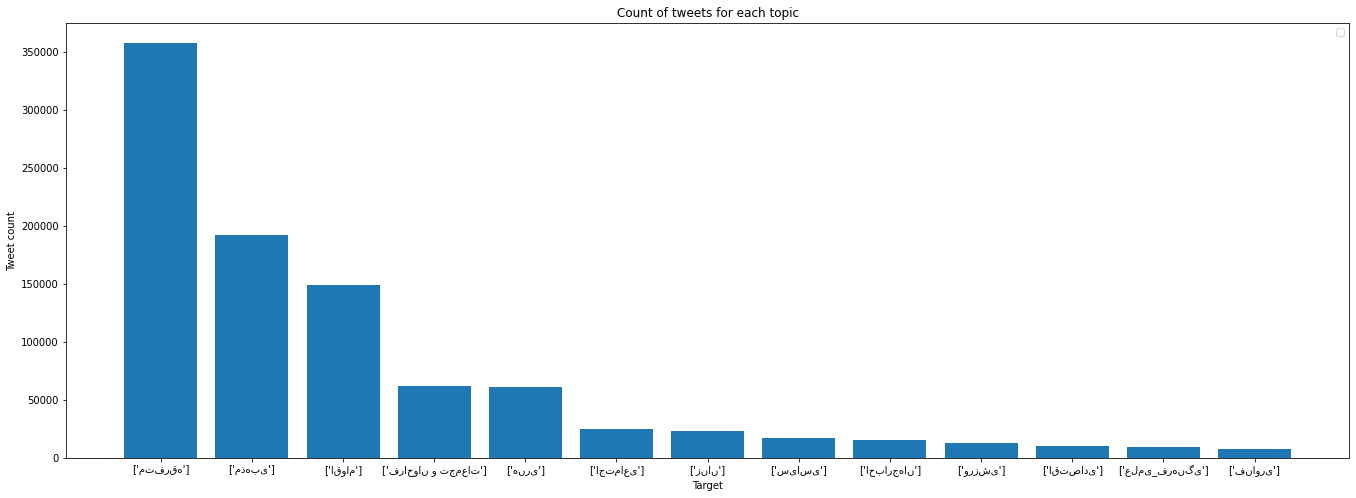

In [13]:
class_count = data['target'].value_counts()
plt.figure(figsize = (23, 8))
plt.bar(x = class_count.keys(), 
        height = class_count.values)
plt.xlabel("Target")
plt.ylabel("Tweet count")
plt.title("Count of tweets for each topic")
plt.legend()

In [14]:
is_fa =  data['lang'] == 'fa'
fa_data = data[is_fa]
fa_data.head()

,lang,text,target
1,fa,آن شب اسفندماه که برای نخستین بار خبر درگذشت #...,['اجتماعی']
3,fa,جدا از رفتن شجریان، چهر‌ه‌های غمبار همایون و ع...,['هنری']
4,fa,دیگه تویی که تا دیروز عکس سردار دلها رو استوری...,['هنری']
5,fa,لازم نیست راجع‌به هر مسئله‌ای نظر بدی و موضع‌گ...,['مذهبی']
6,fa,به نظر من اینکه رفیق صمیمیت لانگ دیستنس باشه ب...,['مذهبی']


In [15]:
fa_data.shape

(337104, 3)

In [16]:
is_en =  data['lang'] == 'en'
en_data= data[is_en]
en_data.head()

,lang,text,target
2,en,@daydreaminblack Niiiice😂😂😂😂😂,['متفرقه']
23,en,@safewordthe۲nd ….,['متفرقه']
39,en,"@wahid_taniwal It seems, Taliban endorsed Pres...",['متفرقه']
40,en,"Mujahid told CBS News in a phone interview, «W...",['متفرقه']
41,en,"With fragile peace talks, the #COVID-۱۹ pandem...",['متفرقه']


In [17]:
en_data.shape

(286065, 3)

#Preprocess

##X

In [18]:
def tokenizer(text):
  text = text.str.split(' ')
  return text

In [19]:
def stemLemmaStopWord(stemmer, lemmatizer, stopwords, alphabet, tokens):
  final_tokens = []
  for token in tokens:
    stemmed_token = stemmer.stem(lemmatizer.lemmatize(token))
    if '#' in stemmed_token:
      stemmed_token = stemmed_token.split('#')[0]
    if token not in stopwords and stemmed_token not in stopwords and not token == '' and stemmed_token not in alphabet:
      final_tokens.append(stemmed_token)
  return final_tokens

In [20]:
def num_words(words):
  return len(words)

def num_distinct_words(words):
  return len(set(words))

def all_words(data):
  words = set()
  for text in data.text:
    for word in text:
      words.add(word)
  return words

###farsi

In [21]:
fa_data.head()

,lang,text,target
1,fa,آن شب اسفندماه که برای نخستین بار خبر درگذشت #...,['اجتماعی']
3,fa,جدا از رفتن شجریان، چهر‌ه‌های غمبار همایون و ع...,['هنری']
4,fa,دیگه تویی که تا دیروز عکس سردار دلها رو استوری...,['هنری']
5,fa,لازم نیست راجع‌به هر مسئله‌ای نظر بدی و موضع‌گ...,['مذهبی']
6,fa,به نظر من اینکه رفیق صمیمیت لانگ دیستنس باشه ب...,['مذهبی']


In [22]:
def fa_normalize(text):
  text = text.replace(to_replace =r"[ئيی]", value = 'ی', regex = True)
  text = text.replace(to_replace =r"[ك]", value = 'ک', regex = True)
  text = text.replace(to_replace =r"[ؤ]", value = 'و', regex = True)
  text = text.replace(to_replace =r"[ة]", value = 'ه', regex = True)
  text = text.replace(to_replace=r"[إأآا]", value="ا", regex=True)
  text = text.replace(
            to_replace=r"[^ابپتثجچحخدذرزژسشصضطظعغفقکگلمنوهی]", value=" ", regex=True
        )
  text = text.replace(to_replace=r'(.)\1+', value=r'\1', regex=True)
  text = text.replace(to_replace =r"[^\S\n\t]+", value = ' ', regex = True)
  return text  


fa_data.text = fa_normalize(fa_data.text)
fa_data.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,lang,text,target
1,fa,ان شب اسفندماه که برای نخستین بار خبر درگذشت م...,['اجتماعی']
3,fa,جدا از رفتن شجریان چهر ه های غمبار همایون و عل...,['هنری']
4,fa,دیگه توی که تا دیروز عکس سردار دلها رو استوری ...,['هنری']
5,fa,لازم نیست راجع به هر مسیله ای نظر بدی و موضع گ...,['مذهبی']
6,fa,به نظر من اینکه رفیق صمیمیت لانگ دیستنس باشه ب...,['مذهبی']


tokenize

In [23]:
fa_data.text = tokenizer(fa_data.text)
fa_data.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,lang,text,target
1,fa,"[ان, شب, اسفندماه, که, برای, نخستین, بار, خبر,...",['اجتماعی']
3,fa,"[جدا, از, رفتن, شجریان, چهر, ه, های, غمبار, هم...",['هنری']
4,fa,"[دیگه, توی, که, تا, دیروز, عکس, سردار, دلها, ر...",['هنری']
5,fa,"[لازم, نیست, راجع, به, هر, مسیله, ای, نظر, بدی...",['مذهبی']
6,fa,"[به, نظر, من, اینکه, رفیق, صمیمیت, لانگ, دیستن...",['مذهبی']


Stem Lemma StopWord

In [24]:
fa_stemmer = hazm.Stemmer()
fa_lemmatizer = hazm.Lemmatizer()
fa_stopwords = hazm.stopwords_list()
fa_alphabet = set(list('ابپتثجچحخدذرزژسشصضطظعغفقکگلمنوهی'))

fa_data.text = fa_data.apply(lambda row: stemLemmaStopWord(fa_stemmer, fa_lemmatizer, fa_stopwords, fa_alphabet, row.text), axis=1)
fa_data.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,lang,text,target
1,fa,"[, شب, اسفندماه, خبر, درگذ, محمدرضاشجر, امد, م...",['اجتماعی']
3,fa,"[جدا, رفتن, شجر, چهر, , غمبار, همایون, علیزاده...",['هنری']
4,fa,"[دیگه, دیروز, عکس, سردار, دل, استور, میکرد, نم...",['هنری']
5,fa,"[راجع, مسیله, بد, موضع, ]",['مذهبی']
6,fa,"[رفیق, صمیم, لانگ, دیستنس, باشه, مراتب, سخ, , ...",['مذهبی']


number of words

In [25]:
fa_data['words_num'] = fa_data.apply(lambda row: num_words(row.text), axis=1)
fa_data['distinct_words_num'] = fa_data.apply(lambda row: num_distinct_words(row.text), axis=1)
fa_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,lang,text,target,words_num,distinct_words_num
1,fa,"[, شب, اسفندماه, خبر, درگذ, محمدرضاشجر, امد, م...",['اجتماعی'],28,24
3,fa,"[جدا, رفتن, شجر, چهر, , غمبار, همایون, علیزاده...",['هنری'],11,11
4,fa,"[دیگه, دیروز, عکس, سردار, دل, استور, میکرد, نم...",['هنری'],12,12
5,fa,"[راجع, مسیله, بد, موضع, ]",['مذهبی'],5,5
6,fa,"[رفیق, صمیم, لانگ, دیستنس, باشه, مراتب, سخ, , ...",['مذهبی'],12,10


In [26]:
words = all_words(fa_data)
print('all farsi words: ', sum(fa_data.words_num), ' and distinct farsi words: ', len(words))

all farsi words:  3658226  and distinct farsi words:  94030


###english

In [27]:
en_data.head()

,lang,text,target
2,en,@daydreaminblack Niiiice😂😂😂😂😂,['متفرقه']
23,en,@safewordthe۲nd ….,['متفرقه']
39,en,"@wahid_taniwal It seems, Taliban endorsed Pres...",['متفرقه']
40,en,"Mujahid told CBS News in a phone interview, «W...",['متفرقه']
41,en,"With fragile peace talks, the #COVID-۱۹ pandem...",['متفرقه']


In [28]:
def en_normalize(text):
  text = text.replace(to_replace =r'@([A-Za-z0-9_]+)', value = '', regex = True)
  text = text.replace(to_replace=r"http([^\s\\]+)", value="", regex=True)
  text = text.str.lower()
  text = text.replace(to_replace =r"[^a-z]", value = ' ', regex = True)
  text = text.replace(to_replace=r'(.)\1+', value=r'\1', regex=True)
  text = text.replace(to_replace =r"[^\S\n\t]+", value = ' ', regex = True)
  return text  

en_data.text = en_normalize(en_data.text)
en_data.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,lang,text,target
2,en,nice,['متفرقه']
23,en,nd,['متفرقه']
39,en,it sems taliban endorsed president trump nomi...,['متفرقه']
40,en,mujahid told cbs news in a phone interview we ...,['متفرقه']
41,en,with fragile peace talks the covid pandemic an...,['متفرقه']


tokenize

In [29]:
en_data.text = tokenizer(en_data.text)
en_data.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,lang,text,target
2,en,"[, nice, ]",['متفرقه']
23,en,"[, nd, ]",['متفرقه']
39,en,"[, it, sems, taliban, endorsed, president, tru...",['متفرقه']
40,en,"[mujahid, told, cbs, news, in, a, phone, inter...",['متفرقه']
41,en,"[with, fragile, peace, talks, the, covid, pand...",['متفرقه']


Stem Lemma StopWord

In [30]:
en_stemmer = PorterStemmer()
en_lemmatizer = WordNetLemmatizer()
en_stopwords = set(stopwords.words("english"))
en_alphabet = set(list('abcdefghijklmnopqrstuvwxyz'))

en_data.text = en_data.apply(lambda row: stemLemmaStopWord(en_stemmer, en_lemmatizer, en_stopwords, en_alphabet, row.text), axis=1)
en_data.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,lang,text,target
2,en,[nice],['متفرقه']
23,en,[nd],['متفرقه']
39,en,"[sem, taliban, endors, presid, trump, nomin, p...",['متفرقه']
40,en,"[mujahid, told, cb, news, phone, interview, ho...",['متفرقه']
41,en,"[fragil, peac, talk, covid, pandem, new, afgha...",['متفرقه']


number of words

In [31]:
en_data['words_num'] = en_data.apply(lambda row: num_words(row.text), axis=1)
en_data['distinct_words_num'] = en_data.apply(lambda row: num_distinct_words(row.text), axis=1)
en_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,lang,text,target,words_num,distinct_words_num
2,en,[nice],['متفرقه'],1,1
23,en,[nd],['متفرقه'],1,1
39,en,"[sem, taliban, endors, presid, trump, nomin, p...",['متفرقه'],8,8
40,en,"[mujahid, told, cb, news, phone, interview, ho...",['متفرقه'],31,31
41,en,"[fragil, peac, talk, covid, pandem, new, afgha...",['متفرقه'],28,28


In [32]:
words = all_words(en_data)
print('all english words: ', sum(en_data.words_num), ' and distinct english words: ', len(words))

all english words:  2679298  and distinct english words:  212643


##y

####english

No handles with labels found to put in legend.


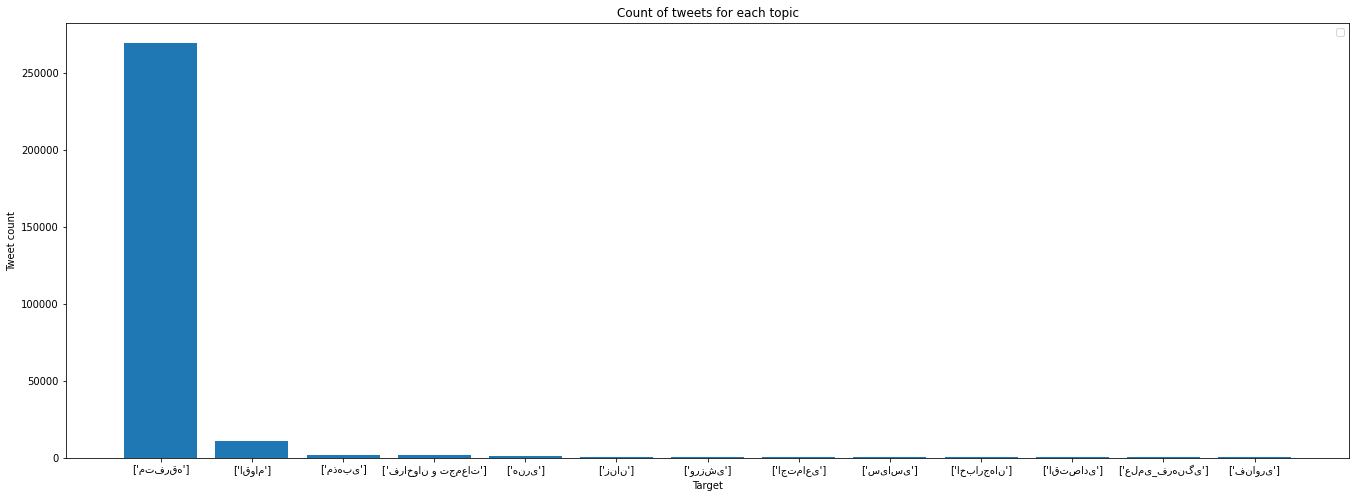

In [33]:
class_count = en_data['target'].value_counts()
plt.figure(figsize = (23, 8))
plt.bar(x = class_count.keys(), 
        height = class_count.values)
plt.xlabel("Target")
plt.ylabel("Tweet count")
plt.title("Count of tweets for each topic")
plt.legend()

then we don't use english data!

####farsi

In [59]:
def tag(a):
  return a[2:-2]
fa_data['new_target'] = fa_data.apply(lambda row: tag(row.target), axis=1)

In [64]:
fa_data = fa_data[['lang', 'text', 'new_target', 'words_num']]

In [66]:
fa_data.columns = ['lang', 'text', 'target', 'words_num']

No handles with labels found to put in legend.


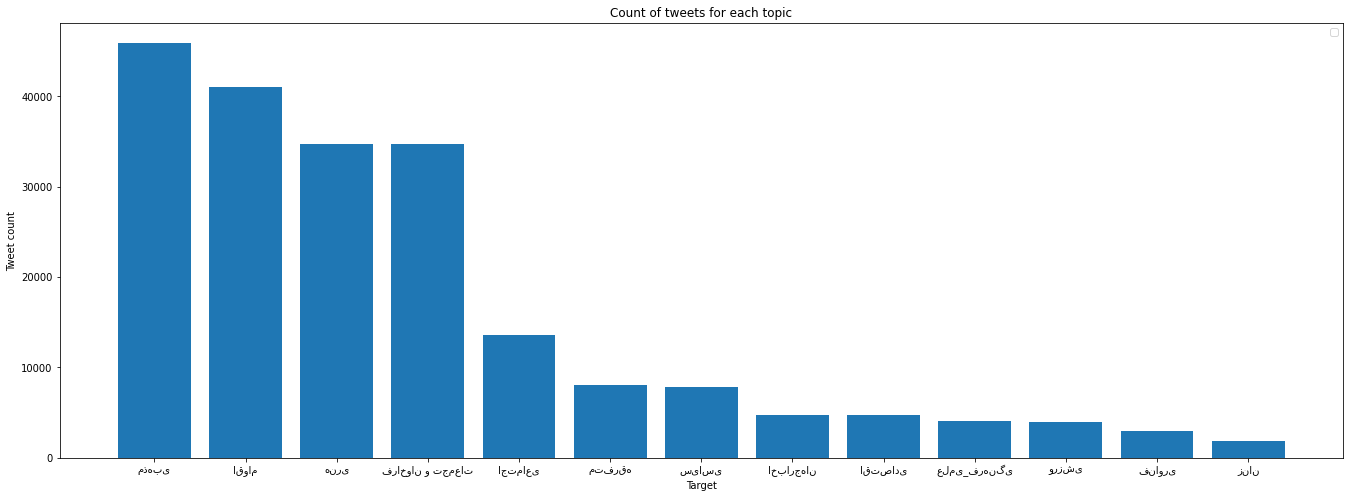

In [67]:
class_count = fa_data['target'].value_counts()
plt.figure(figsize = (23, 8))
plt.bar(x = class_count.keys(), 
        height = class_count.values)
plt.xlabel("Target")
plt.ylabel("Tweet count")
plt.title("Count of tweets for each topic")
plt.legend()

In [68]:
fa_data.shape

(207718, 4)

In [69]:
fa_data = fa_data[fa_data.words_num > 5]

In [70]:
fa_data.shape

(207718, 4)

In [71]:
fa_data = fa_data.reindex(fa_data.words_num.sort_values().index)

In [72]:
fa_data .reset_index(drop=True, inplace=True)

In [73]:
fa_data

,lang,text,target,words_num
0,fa,"[درس, جواب, ندادن, جفا, حق, مسلمینه]",مذهبی,6
1,fa,"[حکم, توانا, گناه, عصم, نهج, البلاغه]",مذهبی,6
2,fa,"[جنب, تعهد, اسرایل, جول, اشغال, خارج]",اخبارجهان,6
3,fa,"[کن, روز, دوبار, تکرار, نخود, خوبه]",هنری,6
4,fa,"[رونما, موشک, بالستیک, قاره, کره, شمال]",اخبارجهان,6
...,...,...,...,...
207713,fa,"[کیف, عن, حبگ, اتوب, ولک, تودین, الدروب, غیرک,...",اقوام,49
207714,fa,"[کیف, عن, حبگ, اتوب, ولک, تودین, الدروب, غیرک,...",اقوام,49
207715,fa,"[کیف, عن, حبگ, اتوب, ولک, تودین, الدروب, غیرک,...",اقوام,49
207716,fa,"[کا, هیشک, مریض, نشه, کا, هیشک, مریض, نشه, کا,...",اقوام,56


In [74]:
tages

["['اقوام']",
 "['اجتماعی']",
 "['مذهبی']",
 "['سیاسی']",
 "['فناوری']",
 "['اقتصادی']",
 "['علمی_فرهنگی']",
 "['متفرقه']",
 "['هنری']",
 "['زنان']",
 "['فراخوان و تجمعات']",
 "['ورزشی']",
 "['اخبارجهان']"]

In [76]:
fa_data_1 = fa_data[fa_data.target == 'فناوری']
fa_data_2 = fa_data[fa_data.target == 'سیاسی']
fa_data_3 = fa_data[fa_data.target == 'متفرقه']
fa_data_4 = fa_data[fa_data.target == 'اقوام']
fa_data_5 = fa_data[fa_data.target == 'زنان']
fa_data_6 = fa_data[fa_data.target == 'علمی_فرهنگی']
fa_data_7 = fa_data[fa_data.target == 'اجتماعی']
fa_data_8 = fa_data[fa_data.target == 'فراخوان و تجمعات']
fa_data_9 = fa_data[fa_data.target == 'مذهبی']
fa_data_10 = fa_data[fa_data.target == 'هنری']
fa_data_11 = fa_data[fa_data.target == 'اخبارجهان']
fa_data_12 = fa_data[fa_data.target == 'ورزشی']
fa_data_13 = fa_data[fa_data.target == 'اقتصادی']

In [77]:
fa_data_11

,lang,text,target,words_num
2,fa,"[جنب, تعهد, اسرایل, جول, اشغال, خارج]",اخبارجهان,6
4,fa,"[رونما, موشک, بالستیک, قاره, کره, شمال]",اخبارجهان,6
16,fa,"[مهر, روز, جهان, مبارزه, حک, اعدا]",اخبارجهان,6
34,fa,"[رضا, چین, توسعه, روابط, کره, شمال]",اخبارجهان,6
50,fa,"[خب, جلسه, دول, هفته, تعویق, افتاد]",اخبارجهان,6
...,...,...,...,...
206939,fa,"[تد, کروز, اوباما, اله, , سیس, مال, جه, وصل, پ...",اخبارجهان,39
207047,fa,"[یه, خبر, خوند, منبع, زد, نوشته, پا, طالب, گلب...",اخبارجهان,39
207138,fa,"[تد, کروز, اوباما, اله, , سیس, مال, جه, وصل, پ...",اخبارجهان,39
207248,fa,"[جشن, هفتاد, پنجمین, سالروز, تاسیس, حزب, کارگر...",اخبارجهان,40


In [78]:
fa_data_1.reset_index(drop=True, inplace=True)
fa_data_2.reset_index(drop=True, inplace=True)
fa_data_3.reset_index(drop=True, inplace=True)
fa_data_4.reset_index(drop=True, inplace=True)
fa_data_5.reset_index(drop=True, inplace=True)
fa_data_6.reset_index(drop=True, inplace=True)
fa_data_7.reset_index(drop=True, inplace=True)
fa_data_8.reset_index(drop=True, inplace=True)
fa_data_9.reset_index(drop=True, inplace=True)
fa_data_10.reset_index(drop=True, inplace=True)
fa_data_11.reset_index(drop=True, inplace=True)
fa_data_12.reset_index(drop=True, inplace=True)
fa_data_13.reset_index(drop=True, inplace=True)

In [79]:
fa_data_11

,lang,text,target,words_num
0,fa,"[جنب, تعهد, اسرایل, جول, اشغال, خارج]",اخبارجهان,6
1,fa,"[رونما, موشک, بالستیک, قاره, کره, شمال]",اخبارجهان,6
2,fa,"[مهر, روز, جهان, مبارزه, حک, اعدا]",اخبارجهان,6
3,fa,"[رضا, چین, توسعه, روابط, کره, شمال]",اخبارجهان,6
4,fa,"[خب, جلسه, دول, هفته, تعویق, افتاد]",اخبارجهان,6
...,...,...,...,...
4663,fa,"[تد, کروز, اوباما, اله, , سیس, مال, جه, وصل, پ...",اخبارجهان,39
4664,fa,"[یه, خبر, خوند, منبع, زد, نوشته, پا, طالب, گلب...",اخبارجهان,39
4665,fa,"[تد, کروز, اوباما, اله, , سیس, مال, جه, وصل, پ...",اخبارجهان,39
4666,fa,"[جشن, هفتاد, پنجمین, سالروز, تاسیس, حزب, کارگر...",اخبارجهان,40


In [87]:
fa_data_4 = fa_data_4[-8000:]
fa_data_7 = fa_data_7[-8000:]
fa_data_8 = fa_data_8[-8000:]
fa_data_9 = fa_data_9[-8000:]
fa_data_10 = fa_data_10[-8000:]

fa_data_4.reset_index(drop=True, inplace=True)
fa_data_7.reset_index(drop=True, inplace=True)
fa_data_8.reset_index(drop=True, inplace=True)
fa_data_9.reset_index(drop=True, inplace=True)
fa_data_10.reset_index(drop=True, inplace=True)

In [88]:
frames = [fa_data_1,fa_data_2,fa_data_3,fa_data_4,fa_data_5,fa_data_6,fa_data_7,fa_data_8,fa_data_9,fa_data_10,fa_data_11,fa_data_12,fa_data_13]
fa_data = pd.concat(frames)

# shuffle
fa_data  = fa_data.sample(frac = 1)
fa_data.reset_index(drop=True, inplace=True)

No handles with labels found to put in legend.


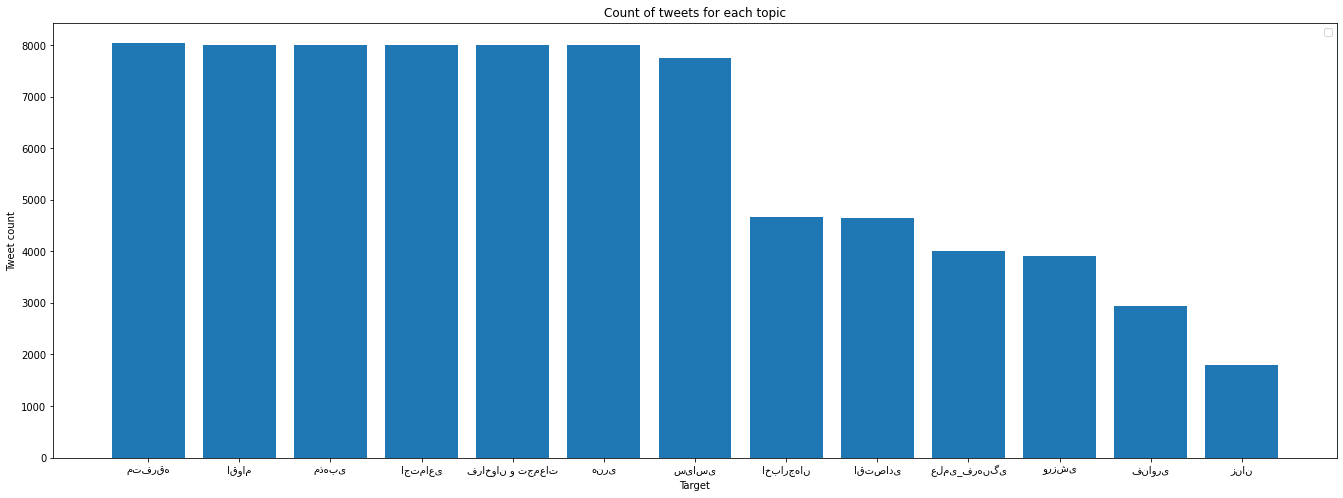

In [89]:
class_count = fa_data['target'].value_counts()
plt.figure(figsize = (23, 8))
plt.bar(x = class_count.keys(), 
        height = class_count.values)
plt.xlabel("Target")
plt.ylabel("Tweet count")
plt.title("Count of tweets for each topic")
plt.legend()

In [90]:
fa_data.shape

(77772, 4)

#prepare test and train sets

devide farsi test and train


In [91]:
total_len = fa_data.shape[0]

train_len = 70*total_len//100
train_fa_data = fa_data.iloc[:train_len, :]
test_fa_data = fa_data.iloc[train_len:, :]

In [32]:
# # dev data
# total_len = test_fa_data.shape[0]
# dev_len = 50*total_len//100
# dev_fa_data = test_fa_data.iloc[:dev_len, :]
# test_fa_data = test_fa_data.iloc[dev_len:, :]

devide english test and train

In [ ]:
total_len = en_data.shape[0]

train_len = 70*total_len//100
train_en_data = en_data.iloc[:train_len, :]
test_en_data = en_data.iloc[train_len:, :]

In [ ]:
# # dev data
# total_len = test_en_data.shape[0]
# dev_len = 50*total_len//100
# dev_en_data = test_en_data.iloc[:dev_len, :]
# test_en_data = test_en_data.iloc[dev_len:, :]

merge farsi and english data

In [ ]:
frames = [train_en_data, train_fa_data]
train_bilang_data = pd.concat(frames)

frames = [test_en_data, test_fa_data]
test_bilang_data = pd.concat(frames)

# frames = [dev_en_data, dev_fa_data]
# dev_bilang_data = pd.concat(frames)

# shuffle
train_bilang_data  = train_bilang_data .sample(frac = 1)
train_bilang_data .reset_index(drop=True, inplace=True)

test_bilang_data  = test_bilang_data .sample(frac = 1)
test_bilang_data .reset_index(drop=True, inplace=True)

# dev_bilang_data  = dev_bilang_data .sample(frac = 1)
# dev_bilang_data .reset_index(drop=True, inplace=True)

#Vectorizer

devide farsi X and y

In [92]:
X_fa_train = train_fa_data.text.apply(lambda x: np.str_(x))
y_fa_train = train_fa_data.target

X_fa_test = test_fa_data.text.apply(lambda x: np.str_(x))
y_fa_test = test_fa_data.target

# X_fa_dev = dev_fa_data.text.apply(lambda x: np.str_(x))
# y_fa_dev = dev_fa_data.target

devide english X and y

In [ ]:
X_en_train = train_en_data.text.apply(lambda x: np.str_(x))
y_en_train = train_en_data.target

X_en_test = test_en_data.text.apply(lambda x: np.str_(x))
y_en_test = test_en_data.target

# X_en_dev = dev_en_data.text.apply(lambda x: np.str_(x))
# y_en_dev = dev_en_data.target

devide farsi and english X and y

In [ ]:
X_bilang_train = train_bilang_data.text.apply(lambda x: np.str_(x))
y_bilang_train = train_bilang_data.target

X_bilang_test = test_bilang_data.text.apply(lambda x: np.str_(x))
y_bilang_test = test_bilang_data.target

# X_bilang_dev = dev_bilang_data.text.apply(lambda x: np.str_(x))
# y_bilang_dev = dev_bilang_data.target

TF IDF

farsi

In [93]:
tfidfVectorizer = TfidfVectorizer(min_df = 5, max_features = 1000)
tfidfVectorizer.fit(X_fa_train)
X_train_fa_vector = tfidfVectorizer.transform(X_fa_train)
X_test_fa_vector = tfidfVectorizer.transform(X_fa_test)
# X_dev_fa_vector = tfidfVectorizer.transform(X_fa_dev)

# save
filename = 'tfidf_fa.sav'
pickle.dump(tfidfVectorizer, open(filename, 'wb'))

english

In [ ]:
tfidfVectorizer.fit(X_en_train)
X_train_en_vector = tfidfVectorizer.transform(X_en_train)
X_test_en_vector = tfidfVectorizer.transform(X_en_test)
# X_dev_en_vector = tfidfVectorizer.transform(X_en_dev)

# save
filename = 'tfidf_en.sav'
pickle.dump(tfidfVectorizer, open(filename, 'wb'))

farsi and english

In [ ]:
tfidfVectorizer.fit(X_bilang_train)
X_train_bilang_vector = tfidfVectorizer.transform(X_bilang_train)
X_test_bilang_vector = tfidfVectorizer.transform(X_bilang_test)
# X_dev_bilang_vector = tfidfVectorizer.transform(X_bilang_dev)

# save
filename = 'tfidf_bilang.sav'
pickle.dump(tfidfVectorizer, open(filename, 'wb'))

#NB

farsi

In [95]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train_fa_vector, y_fa_train)
prediction_fa = nb_model.predict(X_test_fa_vector)
print(classification_report(y_fa_test, prediction_fa))

                  precision    recall  f1-score   support

         اجتماعی       0.50      0.50      0.50      2433
       اخبارجهان       0.59      0.60      0.60      1359
         اقتصادی       0.70      0.67      0.68      1382
           اقوام       0.45      0.42      0.44      2394
            زنان       0.35      0.07      0.11       502
           سیاسی       0.54      0.61      0.57      2317
     علمی_فرهنگی       0.62      0.25      0.35      1215
فراخوان و تجمعات       0.53      0.49      0.51      2429
          فناوری       0.51      0.25      0.33       881
          متفرقه       0.51      0.43      0.47      2369
           مذهبی       0.34      0.56      0.43      2418
            هنری       0.54      0.70      0.61      2474
           ورزشی       0.61      0.51      0.56      1159

        accuracy                           0.51     23332
       macro avg       0.52      0.47      0.47     23332
    weighted avg       0.52      0.51      0.50     23332



In [35]:
filename = 'nb_fa.sav'
pickle.dump(nb_model, open(filename, 'wb'))

english

In [ ]:
nb_model.fit(X_train_en_vector, y_en_train)
prediction_en = nb_model.predict(X_test_en_vector)
print(classification_report(y_en_test, prediction_en))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                      precision    recall  f1-score   support

         ['اجتماعی']       0.00      0.00      0.00        80
       ['اخبارجهان']       0.00      0.00      0.00        76
         ['اقتصادی']       0.00      0.00      0.00        39
           ['اقوام']       0.75      0.00      0.00      3052
            ['زنان']       0.00      0.00      0.00       189
           ['سیاسی']       0.00      0.00      0.00        79
     ['علمی_فرهنگی']       0.00      0.00      0.00        53
['فراخوان و تجمعات']       0.67      0.05      0.10       427
          ['فناوری']       0.00      0.00      0.00        32
          ['متفرقه']       0.94      1.00      0.97     80780
           ['مذهبی']       1.00      0.03      0.05       620
            ['هنری']       0.00      0.00      0.00       276
           ['ورزشی']       0.00      0.00      0.00       117

            accuracy                           0.94     85820
           macro avg       0.26      0.08      0.09     85820
      

In [ ]:
filename = 'nb_en.sav'
pickle.dump(nb_model, open(filename, 'wb'))

farsi and english

In [ ]:
nb_model.fit(X_train_bilang_vector, y_bilang_train)
prediction_bilang = nb_model.predict(X_test_bilang_vector)
print(classification_report(y_bilang_test, prediction_bilang))

                      precision    recall  f1-score   support

         ['اجتماعی']       0.44      0.14      0.22      6204
       ['اخبارجهان']       0.49      0.23      0.32      2040
         ['اقتصادی']       0.74      0.33      0.46      2108
           ['اقوام']       0.34      0.43      0.38     25171
            ['زنان']       0.52      0.03      0.05      2350
           ['سیاسی']       0.52      0.27      0.36      3442
     ['علمی_فرهنگی']       0.66      0.08      0.15      2146
['فراخوان و تجمعات']       0.53      0.39      0.45     16799
          ['فناوری']       0.53      0.01      0.01      1718
          ['متفرقه']       0.86      0.96      0.91     85258
           ['مذهبی']       0.41      0.51      0.45     21139
            ['هنری']       0.54      0.49      0.51     16019
           ['ورزشی']       0.55      0.14      0.23      2558

            accuracy                           0.65    186952
           macro avg       0.55      0.31      0.34    186952
      

In [ ]:
filename = 'nb_bilang.sav'
pickle.dump(nb_model, open(filename, 'wb'))

#RF

##tune

In [ ]:
parameters = {#'n_estimators': (10, 30, 50, 70, 90),
              #'criterion': ('gini', 'entropy'),
              'max_depth': (200, 250, 300),
              #'max_features': ('auto', 'sqrt'),
              #'min_samples_split': (2, 3),
              'min_samples_leaf': (15, 20),
              # 'bootstrap' : (True, False),
              #'min_weight_fraction_leaf': (0.0, 0.1, 0.2, 0.3, 0.4)    
}

In [ ]:
rf_grid = GridSearchCV(RandomForestClassifier(n_jobs = -1, oob_score = False), param_grid = parameters, cv = 3, verbose = True)

farsi

In [ ]:
rf_grid_model = rf_grid.fit(X_dev_fa_vector, y_fa_dev)
rf_grid_model.best_estimator_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  2.0min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=300, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=15, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

english

In [ ]:
rf_grid_model = rf_grid.fit(X_dev_en_vector, y_en_dev)
rf_grid_model.best_estimator_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   49.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

farsi and english

In [ ]:
rf_grid_model = rf_grid.fit(X_dev_bilang_vector, y_bilang_dev)
rf_grid_model.best_estimator_

##train and evaluate

farsi

In [97]:
randomForestClassifier = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=300, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
randomForestClassifier.fit(X_train_fa_vector, y_fa_train)
prediction_fa = randomForestClassifier.predict(X_test_fa_vector)
print(classification_report(y_fa_test, prediction_fa))

filename = 'rf_fa.sav'
pickle.dump(randomForestClassifier, open(filename, 'wb'))

                  precision    recall  f1-score   support

         اجتماعی       0.64      0.61      0.62      2433
       اخبارجهان       0.70      0.69      0.69      1359
         اقتصادی       0.67      0.70      0.69      1382
           اقوام       0.76      0.59      0.66      2394
            زنان       0.37      0.24      0.29       502
           سیاسی       0.66      0.72      0.69      2317
     علمی_فرهنگی       0.67      0.41      0.51      1215
فراخوان و تجمعات       0.74      0.65      0.69      2429
          فناوری       0.54      0.34      0.42       881
          متفرقه       0.47      0.65      0.55      2369
           مذهبی       0.53      0.68      0.60      2418
            هنری       0.70      0.78      0.74      2474
           ورزشی       0.74      0.61      0.67      1159

        accuracy                           0.63     23332
       macro avg       0.63      0.59      0.60     23332
    weighted avg       0.64      0.63      0.63     23332



english

In [ ]:
randomForestClassifier = RandomForestClassifier()
randomForestClassifier.fit(X_train_en_vector, y_en_train)
prediction_en = randomForestClassifier.predict(X_test_en_vector)
print(classification_report(y_en_test, prediction_en))

filename = 'rf_en.sav'
pickle.dump(randomForestClassifier, open(filename, 'wb'))

farsi and english

In [ ]:
randomForestClassifier.fit(X_train_bilang_vector, y_bilang_train)
prediction_bilang = randomForestClassifier.predict(X_test_bilang_vector)
print(classification_report(y_bilang_test, prediction_bilang))

filename = 'rf_bilang.sav'
pickle.dump(randomForestClassifier, open(filename, 'wb'))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                      precision    recall  f1-score   support

         ['اجتماعی']       1.00      0.06      0.11      6204
       ['اخبارجهان']       0.98      0.06      0.12      2040
         ['اقتصادی']       0.92      0.10      0.18      2108
           ['اقوام']       0.39      0.21      0.27     25171
            ['زنان']       0.00      0.00      0.00      2350
           ['سیاسی']       0.99      0.13      0.22      3442
     ['علمی_فرهنگی']       1.00      0.06      0.12      2146
['فراخوان و تجمعات']       0.62      0.25      0.36     16799
          ['فناوری']       1.00      0.01      0.02      1718
          ['متفرقه']       0.59      0.99      0.74     85258
           ['مذهبی']       0.41      0.29      0.34     21139
            ['هنری']       0.68      0.32      0.44     16019
           ['ورزشی']       1.00      0.04      0.08      2558

            accuracy                           0.57    186952
           macro avg       0.74      0.19      0.23    186952
      